Calculating condition "Jennaimages"


Counting pixels: 100%|██████████| 48/48 [00:08<00:00,  5.41it/s]
<ipython-input-1-52dab44b7cf8>:318: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_df = complete_df.append(current_quant_df)


<Figure size 432x288 with 0 Axes>

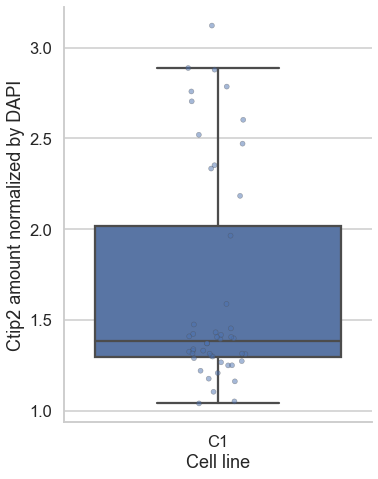

<Figure size 432x288 with 0 Axes>

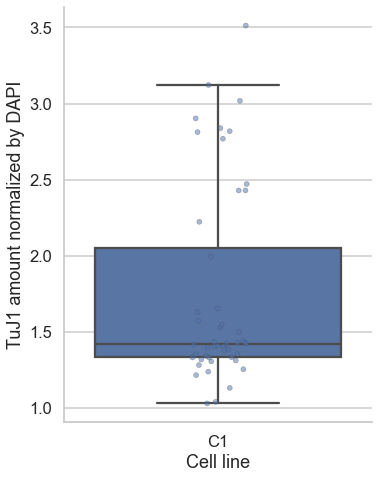

<Figure size 432x288 with 0 Axes>

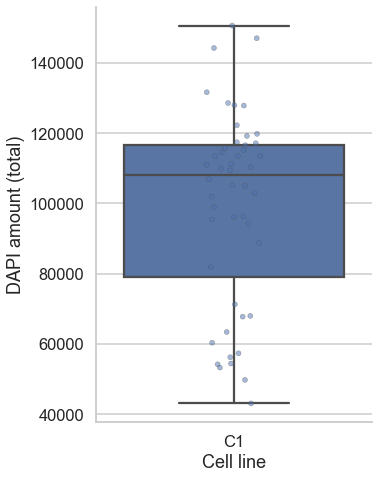

<Figure size 432x288 with 0 Axes>

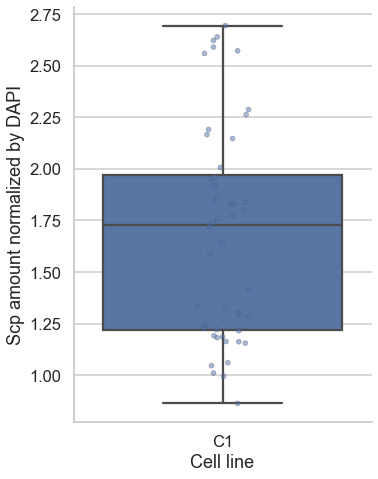

<Figure size 432x288 with 0 Axes>

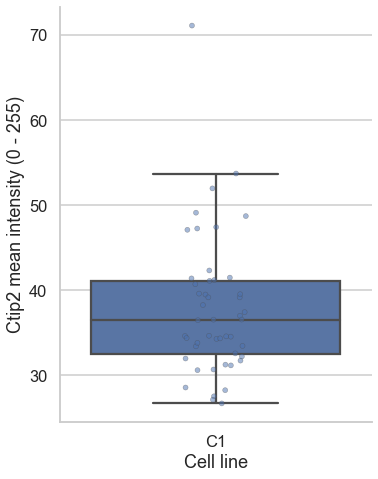

<Figure size 432x288 with 0 Axes>

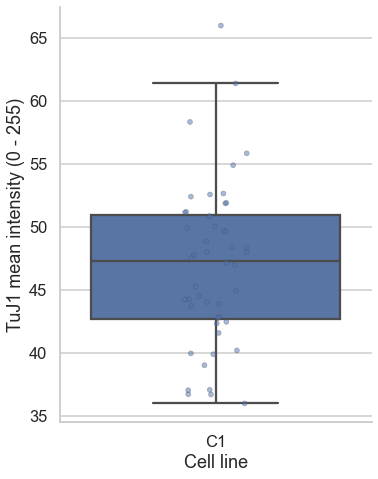

<Figure size 432x288 with 0 Axes>

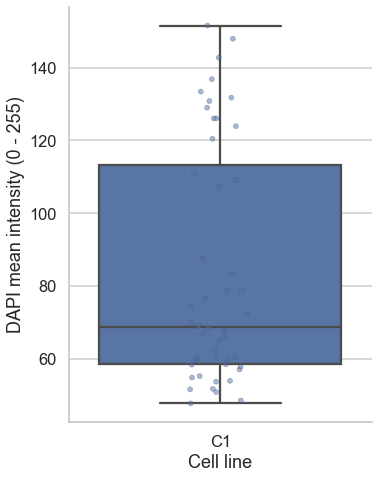

<Figure size 432x288 with 0 Axes>

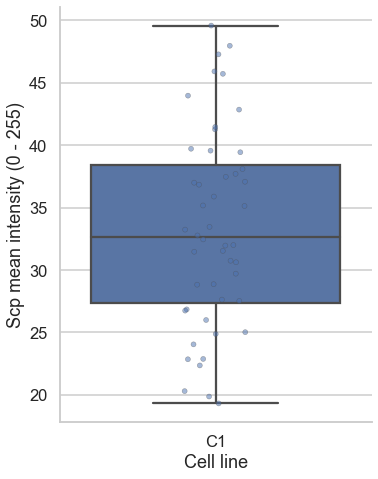

<Figure size 432x288 with 0 Axes>

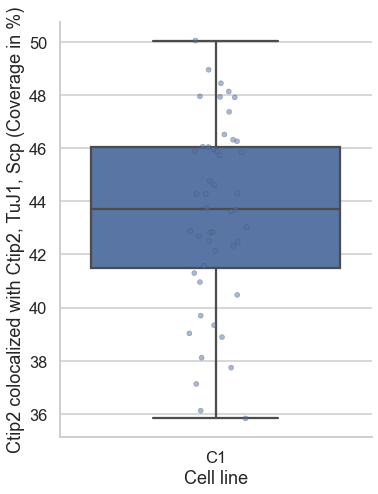

<Figure size 432x288 with 0 Axes>

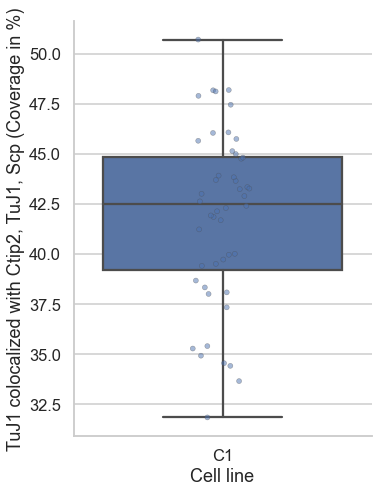

<Figure size 432x288 with 0 Axes>

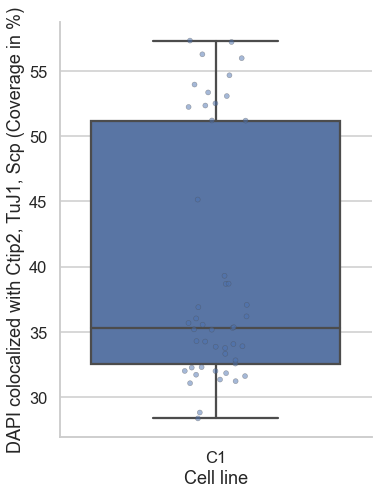

<Figure size 432x288 with 0 Axes>

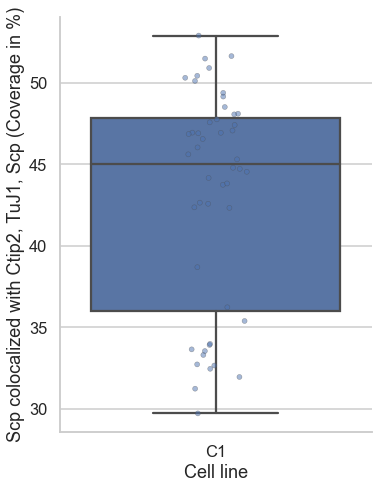

<Figure size 432x288 with 0 Axes>

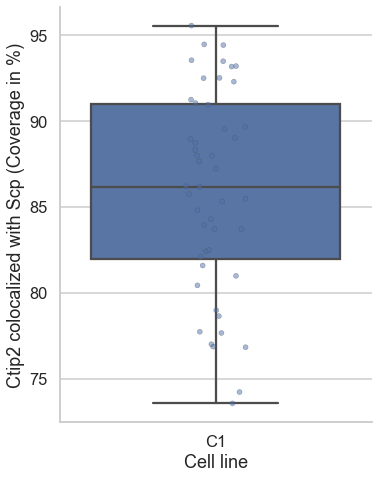

<Figure size 432x288 with 0 Axes>

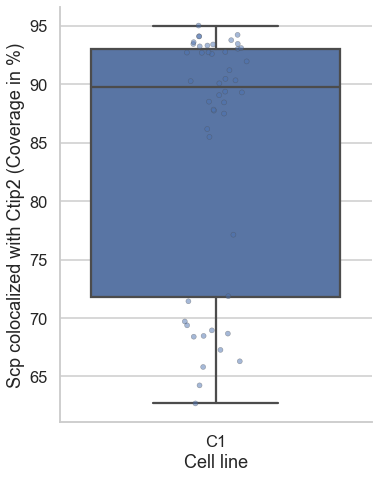

<Figure size 432x288 with 0 Axes>

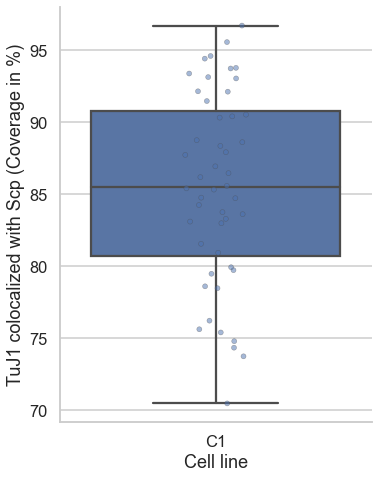

<Figure size 432x288 with 0 Axes>

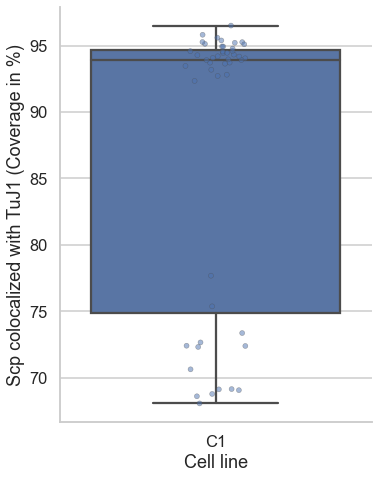

<Figure size 432x288 with 0 Axes>

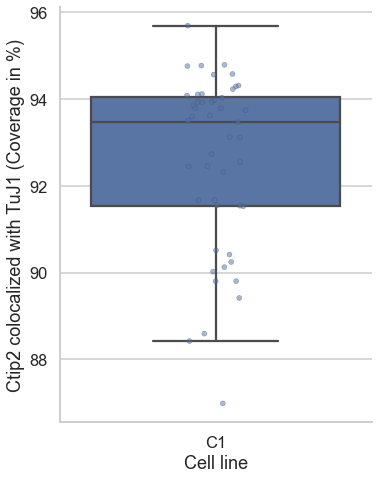

<Figure size 432x288 with 0 Axes>

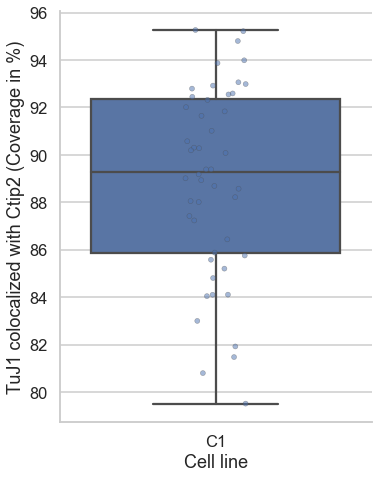

########################################################################





In [1]:
"""
The files "data_preparation.py" and "thresholding.py" need to be executed before this script!
This script will create a mask for each organoid, in which only three markers (ch1, ch2 and ch4) are present ("triple_colocalization").
The mask will be saved with the same file_name, but with an additional "mask"-tag.
This can be used as the colocalization mask for further analysis.
The mean intensity per cell line and marker will be caluclated, as well as
    the total proportion af an marker compared to the DAPI-channel (``ch3``) and
    the percentage of a marker's appearance in the intersection mask.
Additionally, some other "dual-channel-colocalitions" will be calculated, meaning each marker's amount at the same position as another marker.

Change your file path to where all your image folders to analyze are located.
The folder name with the images in it should be called "thresholded_<threshold_mode>".
Select a previously applied thresholding method (threshold_type).
Select a previously applied gaussian filter (gaussian_filter).
These declarations are necessary for the script to find the correct files.
Select, if you want to save the "triple_colocalization"-masks as files or not.

Copyright (c) 2022, Maximilian Otto, Berlin.
"""
# ----------------------------------------------------------------------------------------------- #
# Path of the folder containing all the folders with thresholded images
wd = "S:/mdc_work/jenna"

# Set the normal/control condition folder name
pic_condition_folder_path = "Jennaimages"
# Other treatments:
# - Antimycin A
# - EDHB
# - hypoxy
# - normal

# File format: 
input_file_format = ".tif"

## The quantification will be applied to the following folders/conditions:
#treatment_list = ["normal", "Antimycin A", "EDHB", "hypoxy"]
treatment_list = ["Jennaimages"]

## Select the previously executed mode, on which the quantification will be performed
threshold_mode = "triangle"
# Other options:
#  - "triangle_on_dapi_intensity_greater_1_on_rest"
#  - "otsu_on_dapi_intensity_greater_1_on_rest"
#  - "otsu_on_dapi_only",
#  - "otsu",
#  - "triangle",
#  - "adaptive"
gauss_blur_filter = False  # Set to True or False, wheter you applied a gaussian filter or not 
save_mask_as_files = True    # Want the area of CHCHD2 and TOM20 (colocalization) saved as an image? 

## Names of the markers as in the file names.
# e.g. "C3" mis the notation for DAPI. 'C' stands apperantly for "channel" and '3' is its number, set by the microscope.
ch_prefix = "C" 
ch1_suffix = "1"
ch2_suffix = "2"
ch3_suffix = "3"
ch4_suffix = "4"

## The Real names of the markers.
ch1_real_name = "Ctip2" 
ch2_real_name = "TuJ1"
ch3_real_name = "DAPI"
ch4_real_name = "Scp"

## Jenna's input:
# ch1 is ctip2
# ch2 is tuj1
# ch3 is DAPI
# ch4 is scp

## What we want to find out:
#  - amount of a marker, mormalized by DAPI
#
#  - mean intensity of every seperate color channel per image (ch1, ch2, ch3, ch4)
#
#  - tripple colocalization of ch1, ch2 and ch4
#  - proportion of each individual marker in the intersection mask
#  - save the area of the intersection mask
#
#  - colocalization of ch1 and ch4
#  - colocalization of ch4 and ch1  
#  - colocalization of ch2 and ch4
#  - colocalization of ch4 and ch2
#  - colocalization of ch1 and ch2 
#  - colocalization of ch2 and ch1
# ----------------------------------------------------------------------------------------------- #

import pandas as pd
import glob
import os
import glob
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from tqdm import tqdm

pic_folder_path = os.path.join(wd, pic_condition_folder_path)
os.chdir(pic_folder_path)

base_channel_name = ch_prefix + ch1_suffix


def read_4_color_channels(file_name):
    ch1 = cv2.imread(file_name, -1)
    ch2 = cv2.imread(file_name.replace(base_channel_name, ch_prefix + ch2_suffix), -1)
    ch3 = cv2.imread(file_name.replace(base_channel_name, ch_prefix + ch3_suffix), -1)
    ch4 = cv2.imread(file_name.replace(base_channel_name, ch_prefix + ch4_suffix), -1)
    # Calculate the triple_coloc_mask, where all 3 markers are present
    mask_ch1_ch2_ch4 = cv2.bitwise_and(ch1, ch2)
    mask_ch1_ch2_ch4 = cv2.bitwise_and(mask_ch1_ch2_ch4, ch4)
    # Save the mask as a file
    if save_mask_as_files & (not os.path.isfile(file_name.replace("thresholded", "mask"))):
        cv2.imwrite(os.path.basename(file_name.replace("thresholded", "mask_ch1_ch2_ch4")), mask_ch1_ch2_ch4)
    # Transform the amsk to a binary mask
    mask_ch1_ch2_ch4 = mask_ch1_ch2_ch4 > 0
    return ch1, ch2, ch3, ch4, mask_ch1_ch2_ch4


def calculate_values_of_interest(pic_folder_path, treatment_var="normal", threshold_mode="triangle_on_dapi_intensity_greater_1_on_rest", gaussian_filter=False, save_mask=False):
    # Lists, in which all values of interest of all files within a folder will be stored to
    file_names = []

    ch1_counts_total_normalized = []
    ch2_counts_total_normalized = []
    ch3_counts_total_normalized = []
    ch4_counts_total_normalized = []
    
    mean_intensities_ch1 = []
    mean_intensities_ch2 = []
    mean_intensities_ch3 = []
    mean_intensities_ch4 = []

    percentages_of_ch1_in_mask = []
    percentages_of_ch2_in_mask = []
    percentages_of_ch3_in_mask = []
    percentages_of_ch4_in_mask = []

    percentages_of_ch1_in_ch4 = []
    percentages_of_ch4_in_ch1 = []
    percentages_of_ch2_in_ch4 = []
    percentages_of_ch4_in_ch2 = []
    percentages_of_ch1_in_ch2 = []
    percentages_of_ch2_in_ch1 = []

    gaussian_filters = []
    threshold_types = []

    os.chdir(pic_folder_path + "_thresholded_" + threshold_mode)

    for file in tqdm(glob.glob(pic_folder_path + "_thresholded_" + threshold_mode + "/*" + base_channel_name + "*thresholded*"), desc="Counting pixels"):
        # Read the marker images of each organoid and the "triple-colocalization"-mask
        ch1, ch2, ch3, ch4, mask_ch1_ch2_ch4 = read_4_color_channels(file)

        # How many pixles of a color channel have intensity > 0?
        ch1_count_total = ch1[ch1 > 0].size 
        ch2_count_total = ch2[ch2 > 0].size
        ch3_count_total = ch3[ch3 > 0].size
        ch4_count_total = ch4[ch4 > 0].size

        # Normalize the amounts of each marker by the total amount of DAPI-pixels
        # Normalizing ch3 with ch3 will always give us '1', so we don't do that. 
        ch1_count_total_normalized = ch1_count_total / ch3_count_total
        ch2_count_total_normalized = ch2_count_total / ch3_count_total
        ch3_count_total_normalized = ch3_count_total
        ch4_count_total_normalized = ch4_count_total / ch3_count_total

        # Get mean intensity of each marker
        ch1_mean_greater_than_zero = ch1[ch1 > 0].mean()
        ch2_mean_greater_than_zero = ch2[ch2 > 0].mean()
        ch3_mean_greater_than_zero = ch3[ch3 > 0].mean()
        ch4_mean_greater_than_zero = ch4[ch4 > 0].mean()

        # Get the amount of all values > 0 that are colocalized with (ch1 AND ch2 AND ch4)
        ch1_count_in_mask = ch1[mask_ch1_ch2_ch4].size
        ch2_count_in_mask = ch2[mask_ch1_ch2_ch4].size
        ch3_count_in_mask = ch3[(ch3 > 0) & mask_ch1_ch2_ch4].size
        ch4_count_in_mask = ch4[mask_ch1_ch2_ch4].size

        # Calculate the percentage of ch1, ch2, ch3 and ch4 that are within in the mask
        percentage_of_ch1_in_mask = ch1_count_in_mask / ch1_count_total * 100
        percentage_of_ch2_in_mask = ch2_count_in_mask / ch2_count_total * 100
        percentage_of_ch3_in_mask = ch3_count_in_mask / ch3_count_total * 100
        percentage_of_ch4_in_mask = ch4_count_in_mask / ch4_count_total * 100

        # Colocalizing one channel within another
        percentage_of_ch1_in_ch4 = ch1[(ch1 > 0) & (ch4 > 0)].size / ch1_count_total * 100
        percentage_of_ch4_in_ch1 = ch4[(ch4 > 0) & (ch1 > 0)].size / ch4_count_total * 100

        percentage_of_ch2_in_ch4 = ch2[(ch2 > 0) & (ch4 > 0)].size / ch2_count_total * 100
        percentage_of_ch4_in_ch2 = ch4[(ch4 > 0) & (ch2 > 0)].size / ch4_count_total * 100

        percentage_of_ch1_in_ch2 = ch1[(ch1 > 0) & (ch2 > 0)].size / ch1_count_total * 100
        percentage_of_ch2_in_ch1 = ch2[(ch2 > 0) & (ch1 > 0)].size / ch2_count_total * 100

        # Append the values to the lists
        file_names.append(os.path.basename(file))

        ch1_counts_total_normalized.append(ch1_count_total_normalized)
        ch2_counts_total_normalized.append(ch2_count_total_normalized)
        ch3_counts_total_normalized.append(ch3_count_total_normalized)
        ch4_counts_total_normalized.append(ch4_count_total_normalized)

        mean_intensities_ch1.append(ch1_mean_greater_than_zero)
        mean_intensities_ch2.append(ch2_mean_greater_than_zero)
        mean_intensities_ch3.append(ch3_mean_greater_than_zero)
        mean_intensities_ch4.append(ch4_mean_greater_than_zero)

        percentages_of_ch1_in_mask.append(percentage_of_ch1_in_mask)
        percentages_of_ch2_in_mask.append(percentage_of_ch2_in_mask)
        percentages_of_ch3_in_mask.append(percentage_of_ch3_in_mask)
        percentages_of_ch4_in_mask.append(percentage_of_ch4_in_mask)

        percentages_of_ch1_in_ch4.append(percentage_of_ch1_in_ch4)
        percentages_of_ch4_in_ch1.append(percentage_of_ch4_in_ch1)
        percentages_of_ch2_in_ch4.append(percentage_of_ch2_in_ch4)
        percentages_of_ch4_in_ch2.append(percentage_of_ch4_in_ch2)
        percentages_of_ch1_in_ch2.append(percentage_of_ch1_in_ch2)
        percentages_of_ch2_in_ch1.append(percentage_of_ch2_in_ch1)

        gaussian_filters.append(gaussian_filter)
        threshold_types.append(threshold_mode)

    # Create a dataframe with all variables at once to save it to a csv file.
    quantification_df = pd.DataFrame({
                        "File name": file_names,
                        ch1_real_name + " amount normalized by " + ch3_real_name: ch1_counts_total_normalized,
                        ch2_real_name + " amount normalized by " + ch3_real_name: ch2_counts_total_normalized,
                        ch3_real_name + " amount (total)": ch3_counts_total_normalized,
                        ch4_real_name + " amount normalized by " + ch3_real_name: ch4_counts_total_normalized,
                        ch1_real_name + " mean intensity (0 - 255)": mean_intensities_ch1,
                        ch2_real_name + " mean intensity (0 - 255)": mean_intensities_ch2,
                        ch3_real_name + " mean intensity (0 - 255)": mean_intensities_ch3,
                        ch4_real_name + " mean intensity (0 - 255)": mean_intensities_ch4,
                        ch1_real_name + " colocalized with " + ch1_real_name + ", " + ch2_real_name + ", " + ch4_real_name + " (Coverage in %)": percentages_of_ch1_in_mask,
                        ch2_real_name + " colocalized with " + ch1_real_name + ", " + ch2_real_name + ", " + ch4_real_name + " (Coverage in %)": percentages_of_ch2_in_mask,
                        ch3_real_name + " colocalized with " + ch1_real_name + ", " + ch2_real_name + ", " + ch4_real_name + " (Coverage in %)": percentages_of_ch3_in_mask,
                        ch4_real_name + " colocalized with " + ch1_real_name + ", " + ch2_real_name + ", " + ch4_real_name + " (Coverage in %)": percentages_of_ch4_in_mask,
                        ch1_real_name + " colocalized with " + ch4_real_name + " (Coverage in %)": percentages_of_ch1_in_ch4,
                        ch4_real_name + " colocalized with " + ch1_real_name + " (Coverage in %)": percentages_of_ch4_in_ch1,
                        ch2_real_name + " colocalized with " + ch4_real_name + " (Coverage in %)": percentages_of_ch2_in_ch4,
                        ch4_real_name + " colocalized with " + ch2_real_name + " (Coverage in %)": percentages_of_ch4_in_ch2,
                        ch1_real_name + " colocalized with " + ch2_real_name + " (Coverage in %)": percentages_of_ch1_in_ch2,
                        ch2_real_name + " colocalized with " + ch1_real_name + " (Coverage in %)": percentages_of_ch2_in_ch1,
                        "Gaussian filter": gaussian_filters,
                        "Threshold type": threshold_types,
                        "Condition": treatment_var
                        })

    ## Get the cell line and organoid number from the file name
    # - Get the first characters until '_' and the ones after
    quantification_df["Organoid number"] = quantification_df["File name"].str.split("_", expand=True)[1]
    quantification_df["Cell line"] = quantification_df["File name"].str.split("_", expand=True)[0]

    # Save the dataframe to a csv file
    quantification_df.to_csv(pic_folder_path + "_thresholded_" + threshold_mode + "/quantification.csv", index=False)
    return quantification_df

## Sort dataframe by cell line
# currently not in use
def sort_df_by_cell_line(quantification_df):
    return quantification_df.sort_values(by=["Cell line"], inplace=True)

## Plot the boxplots of all the values of interest as individual plots. 
# for each value, the different cell lines, that are present in a folder of a treatment 
#   are in seperate boxplots next to each other.   
# TODO: update this to whatever cell line or condition you want to analyze in ``add_stat_annotation()``
def box_plt_by_cell_line(quantification_df, value_to_plot, pic_folder_path, condition, threshold_mode, show="True"):
    plt.clf()
    sns.set(style="whitegrid")
    sns.set_context("talk")

    sns.catplot(x="Cell line",
                y=value_to_plot,
                kind="box",
                legend=False,
                height=7,
                aspect=0.8,
                data=quantification_df,
                fliersize=0)

    ax = sns.stripplot(x="Cell line",
                        y=value_to_plot,
                        data=quantification_df,
                        jitter=True,
                        dodge=True,
                        marker='o',
                        alpha=0.5,
                        linewidth=0.5)

    # Statistical test for significance of the boxplots
    # Not used for now, 'cuase we don't have different cell lines
    if 0: 
        add_stat_annotation(ax, data=quantification_df, x="Cell line", y=value_to_plot, 
                        box_pairs=[("Control", "Apoe")], 
                        test="t-test_welch", comparisons_correction=None, text_format="star", loc="outside", verbose=2)

    plt.savefig(pic_folder_path + "_thresholded_" +
                threshold_mode + "/plot_" + value_to_plot + "_" + condition + ".png", bbox_inches='tight')
    if show:
        plt.show()
    return


## Run the calculation for every treatment of the list of treatments and append the results to the dataframe
# Create the boxplots for each treatment within its seperated folder
def quantification(treatment_list, threshold_mode="triangle_on_dapi_intensity_greater_1_on_rest", gaussian_filter=False, save_mask=False, pic_folder_path=pic_folder_path):
    # Loop through the treatments
    complete_df = pd.DataFrame()
    for treatment in treatment_list:
        # Get the path of the folder containing the images
        pic_sub_folder_path = treatment
        pic_folder_path = os.path.join(wd, pic_sub_folder_path)
        os.chdir(pic_folder_path)
        print(f"Calculating condition \"" + treatment + "\"")

        current_quant_df = calculate_values_of_interest(pic_folder_path, treatment_var=treatment, gaussian_filter=gauss_blur_filter, threshold_mode=threshold_mode, save_mask=save_mask_as_files)
        complete_df = complete_df.append(current_quant_df)

        for column in complete_df.select_dtypes(include=[float, int]):
            box_plt_by_cell_line(current_quant_df, column, pic_folder_path, treatment, threshold_mode, show="False")

        print("########################################################################\n\n\n")
    return complete_df
complete_df = quantification(treatment_list, threshold_mode, gaussian_filter=False, save_mask=False)



## This is for comparing different treatments, conditions, or cell lines, to generate plots with them next to each other 
# TODO: change the conditions/cell lines to whatever you want to analyze
# The Plots from above, but now with the different treatments/conditions as hues
# - this way the treatments/conditions can be compared side by side.
def box_plt_by_cell_line_comparison(quantification_df, x_value_to_plot, y_value_to_plot, threshold_mode, hue=None, pic_folder_path=pic_folder_path, show=True, save=True): 
    if not os.path.isdir(pic_folder_path + "/../comparison_results" ):
        os.mkdir(pic_folder_path + "/../comparison_results")
    if not os.path.isdir(pic_folder_path + "/../comparison_results/" + threshold_mode ):
        os.mkdir(pic_folder_path + "/../comparison_results/" + threshold_mode)

    # Save the given dataframe as a csv file
    complete_df.to_csv(pic_folder_path + "/../comparison_results/" + threshold_mode + "/quantification_all.csv", index=False)

    box_pairs=[]
    if x_value_to_plot == "Cell line":
        box_pairs = [("305", "JG"), ("306", "JG"),
                    ("308", "JG"), ("70Q", "JG"),]
        if (hue == "Condition") & (len(treatment_list) == 2):
            # box_pairs shall be a cell line of the first treatment and the second treatment
            box_pairs = [(("305", "Antimycin A"), ("305", "normal")), (("306", "Antimycin A"), ("306", "normal")),
                        (("308", "Antimycin A"), ("308", "normal")), (("70Q", "Antimycin A"), ("70Q", "normal")),
                        (("JG", "Antimycin A"), ("JG", "normal"))]

    if x_value_to_plot == "Condition":
        box_pairs = [("normal", "Antimycin A"), ("normal", "EDHB"),
                    ("normal", "hypoxy"), ("Antimycin A", "EDHB"),
                    ("Antimycin A", "hypoxy"), ("EDHB", "hypoxy"),]
        if len(treatment_list) == 2:
            box_pairs = [("normal", "Antimycin A")]

    print(box_pairs)

    plt.clf()
    sns.set(style="whitegrid", rc={'figure.figsize': (4, 12)})
    sns.set_context("talk")
    sns.catplot(x=x_value_to_plot,
                        y=y_value_to_plot,
                        hue=hue,
                        kind="box",
                        legend=False,
                        height=7,
                        aspect=0.8,
                        data=quantification_df,
                        fliersize=0)

    plot = sns.stripplot(x=x_value_to_plot,
                        data=quantification_df,
                        y=y_value_to_plot,
                        hue=hue,
                        jitter=True,
                        dodge=True,
                        marker='o',
                        linewidth=0.5,
                        alpha=0.5)

    add_stat_annotation(plot, data=quantification_df, x=x_value_to_plot, y=y_value_to_plot,
                        hue=hue,
                        box_pairs=box_pairs,
                        test="t-test_welch", comparisons_correction=None, text_format="star", loc="outside", verbose=2)
    handles, labels = plot.get_legend_handles_labels()
    if hue == "Condition":
        plt.legend(handles[len(treatment_list):], labels[len(treatment_list):], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if hue == "Cell line":
        plt.legend(handles[4:], labels[4:], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save:
        plt.savefig(pic_folder_path + "/../comparison_results/" + threshold_mode + "/plot_" + y_value_to_plot + "_all_cell_lines_and_conditions" + ".png", bbox_inches='tight')
    if show:
        plt.show()
    return

# Set the value to plot
x_value_to_plot = "Condition"
if x_value_to_plot == "Condition":
    ori_complete_df = complete_df
    hue = None
if x_value_to_plot == "Cell line":
    hue = "Condition"

# Alternative plots
if 0: 
    x_value_to_plot = "Cell line"
    hue = "Condition"
    for column in complete_df.select_dtypes(include=[float, int]):
        box_plt_by_cell_line_comparison(complete_df, x_value_to_plot, column, threshold_mode, hue=hue, show=False, save=True)